## The Technological Legacy of the Cold War: Military Procurement and US Innovation

Objective: evaluate the causal effect of high-tech US military procurement spending on the formation of regional innovative clusters. If focus specifically on the surge in spending that occured from 1981-1985 during Reagan's first term in office.

#Datasets:
1) Universe of US patents 
2) All procurment contracts by the US Department of Defence (DoD) 1966-2003
3) County-level descriptive variables from a range of sources

I construct a county-year panel from 1966-2003 where:
- X_it = total DoD procurement dollars spent in county i in year t
- Y_it = citation weighted number of patents in county i in year t

Note that the code used to construct the dataset has not been uploaded.

#Sample

The counties included in the sample are those which produce at least one patent and receive one procurement contract in at least 80% of the sample years (these counties have the dummy variable semi_intens = 1).

#Approach:

1) To provide motivating evidence that there is an effect I perform a Difference-in-Difference design comparing the trajectory of patenting between the counties which recieved the largest surge in spending compared to the rest which received less.

2) Approach (1) suffers from the fact that there are factors, such as the presence of universities, which correlate with how much increased funding the county got under Reagan and also effect the growth in patenting over time. To overcome this problem I use an IV approach where the exogeneity of the instrument comes from the exogenous changes in spending of the DoD in specific technological product categories (to read more on the methodology refer to the paper found in folder XXX).

#Set Up

In [5]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jinja2
import importlib.util
from dataclasses import dataclass
from typing import Sequence
from IPython.display import display

plt.style.use('ggplot')

PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / 'data'


## 1. Difference-in-Differences Event Study

The main purpose of the difference-in-difference analysis is to provide motivating evidence that counties which recieved greater funding under Reagan experienced greater follow on innovation.

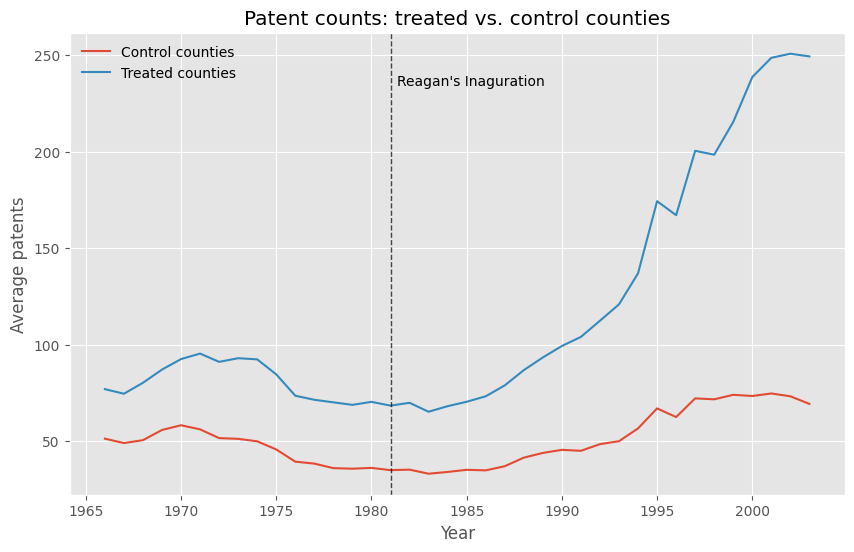

In [ ]:
# Open Datasets 

panel = pd.read_stata(DATA_DIR / 'built.dta')
defcon = pd.read_stata(DATA_DIR / 'defcon_patent_merge_county_year_final.dta')
panel = panel.merge(defcon, on=['county_fips', 'fyear'], how='inner', suffixes=('', '_defcon'))

# Select Sample

panel = panel[(panel['fyear'] >= 1965) & (panel['fyear'] <= 2003)].copy()
panel = panel.drop(columns=['county_id'], errors='ignore')
panel = panel.drop(columns=[c for c in panel.columns if c.endswith('_defcon')], errors='ignore')

panel['semi_intens'] = panel.groupby('county_fips')['semi_intens'].transform('max')
panel = panel[panel['semi_intens'] == 1].copy()

# Compute the pre- and post-surge procurement averages by county

pre_window = panel['fyear'].between(1976, 1981)
post_window = panel['fyear'].between(1981, 1989)
pre_spend = panel.loc[pre_window].groupby('county_fips')['total_dollars'].mean()
post_spend = panel.loc[post_window].groupby('county_fips')['total_dollars'].mean()
panel = panel.join(pre_spend.rename('mean_spend_pre'), on='county_fips')
panel = panel.join(post_spend.rename('mean_spend_post'), on='county_fips')
panel['surge'] = panel['mean_spend_post'] - panel['mean_spend_pre']
surge_cutoff = panel.drop_duplicates('county_fips')['surge'].median()
panel['treated'] = (panel['surge'] > surge_cutoff).astype(int)

panel['after'] = (panel['fyear'] > 1981).astype(int)
panel['treatment'] = panel['after'] * panel['treated']

# Summarise mean outcomes by treatment status and year

event_study = (
    panel.dropna(subset=['num_patents'])
         .groupby(['fyear', 'treated'])['num_patents']
         .mean()
         .reset_index()
)

# Produce Plot

fig, ax = plt.subplots(figsize=(10, 6))
labels = {0: 'Control counties', 1: 'Treated counties'}
for treated, group in event_study.groupby('treated'):
    ax.plot(group['fyear'], group['num_patents'], label=labels[treated])

policy_year = 1981
ax.axvline(policy_year, color='black', linestyle='--', linewidth=1, alpha=0.7)
ax.set_title('Patent count: treated vs. control counties')
ax.set_xlabel('Year')
ax.set_ylabel('Average patents')
ax.legend(frameon=False)
ax.annotate('Reagan\'s Inaguration', xy=(policy_year, ax.get_ylim()[1]), xytext=(5, -30),
            textcoords='offset points', ha='left', va='top', fontsize=10)
plt.show()




The plot shows that, prior to Reagan's first term, there were parallel trends in the patenting activity of the counties which recieved different levels of military funding during his term in office. The figure also suggests that there is a treatment effect, since following Reagan's term in office there is an increasing in patenting amongst the counties which received greater funding that is larger than the increase in the other counties.

## 2. Instrumental Variables Panel Regression

Explain...


In [ ]:

@dataclass(frozen=True)
class IVSpecification:
    label: str
    controls: Sequence[str]
    fixed_effects: Sequence[str]


def residualize_fixed_effects(
    frame: pd.DataFrame,
    columns: Sequence[str],
    fixed_effects: Sequence[str],
    max_iter: int = 100,
    tol: float = 1e-8,
) -> pd.DataFrame:
    """Residualise columns by removing the listed fixed effects via alternating projections."""
    column_names = list(columns)
    residuals = frame[column_names].astype(float).copy()
    if not fixed_effects:
        return residuals

    for _ in range(max_iter):
        previous = residuals.to_numpy(copy=True)
        for effect in fixed_effects:
            means = residuals.groupby(frame[effect])[column_names].transform('mean')
            residuals -= means
        if np.max(np.abs(residuals.to_numpy() - previous)) < tol:
            break

    return residuals


def assemble_matrix(primary: np.ndarray, controls: np.ndarray) -> np.ndarray:
    return np.column_stack([primary, controls]) if controls.size else primary[:, None]


def cluster_robust_vcov(X: np.ndarray, residuals: np.ndarray, clusters: np.ndarray) -> np.ndarray:
    """One-way (county) cluster-robust covariance estimator."""
    XtX = X.T @ X
    XtX_inv = np.linalg.inv(XtX)
    cov = np.zeros((X.shape[1], X.shape[1]))
    clusters = np.asarray(clusters)
    for group_id in np.unique(clusters):
        mask = clusters == group_id
        X_g = X[mask]
        u_g = residuals[mask][:, None]
        cov += X_g.T @ (u_g @ u_g.T) @ X_g
    return XtX_inv @ cov @ XtX_inv


def cluster_robust_iv_cov(
    X: np.ndarray,
    Z: np.ndarray,
    residuals: np.ndarray,
    clusters: np.ndarray,
    ZZ_inv: np.ndarray,
) -> np.ndarray:
    cov = np.zeros((X.shape[1], X.shape[1]))
    clusters = np.asarray(clusters)
    for group_id in np.unique(clusters):
        mask = clusters == group_id
        X_g = X[mask]
        Z_g = Z[mask]
        u_g = residuals[mask][:, None]
        cov += X_g.T @ Z_g @ ZZ_inv @ Z_g.T @ (u_g @ u_g.T) @ Z_g @ ZZ_inv @ Z_g.T @ X_g
    return cov


def fit_ols(y: np.ndarray, endog: np.ndarray, controls: np.ndarray, clusters: np.ndarray):
    X = assemble_matrix(endog, controls)
    beta = np.linalg.solve(X.T @ X, X.T @ y)
    residuals = y - X @ beta
    vcov = cluster_robust_vcov(X, residuals, clusters)
    se = np.sqrt(np.diag(vcov))
    tss = np.square(y - y.mean()).sum()
    rss = np.square(residuals).sum()
    r_squared = 1 - rss / tss if tss > 0 else np.nan
    return beta, se, r_squared


def fit_2sls(
    y: np.ndarray,
    endog: np.ndarray,
    instrument: np.ndarray,
    controls: np.ndarray,
    clusters: np.ndarray,
):
    X = assemble_matrix(endog, controls)
    Z = assemble_matrix(instrument, controls)

    ZZ = Z.T @ Z
    ZZ_inv = np.linalg.inv(ZZ)
    XTZ = X.T @ Z
    bread = np.linalg.inv(XTZ @ ZZ_inv @ XTZ.T)
    beta = bread @ XTZ @ ZZ_inv @ Z.T @ y
    residuals = y - X @ beta

    meat = cluster_robust_iv_cov(X, Z, residuals, clusters, ZZ_inv)
    vcov = bread @ meat @ bread
    se = np.sqrt(np.diag(vcov))

    first_stage_coef = np.linalg.solve(ZZ, Z.T @ endog)
    first_stage_resid = endog - Z @ first_stage_coef
    first_stage_vcov = cluster_robust_vcov(Z, first_stage_resid, clusters)
    first_stage_se = np.sqrt(np.diag(first_stage_vcov))
    first_stage_F = float((first_stage_coef[0] / first_stage_se[0]) ** 2) if first_stage_se[0] != 0 else np.nan

    return beta, se, first_stage_F


def prepare_spec_data(panel: pd.DataFrame, spec: IVSpecification):
    control_columns = list(spec.controls)
    columns = ['lw_cites_sub', 'ltotal_dollars', 'log_spending_6675_iv', *control_columns]
    required = columns + list(spec.fixed_effects) + ['county_fips']

    subset = panel.dropna(subset=required).copy()
    residuals = residualize_fixed_effects(subset, columns, spec.fixed_effects)

    y = residuals['lw_cites_sub'].to_numpy()
    endog = residuals['ltotal_dollars'].to_numpy()
    instrument = residuals['log_spending_6675_iv'].to_numpy()
    controls = residuals[control_columns].to_numpy() if control_columns else np.empty((len(subset), 0))
    clusters = subset['county_fips'].astype(int).to_numpy()
    regressor_names = ['ltotal_dollars', *control_columns]

    return subset, y, endog, instrument, controls, clusters, regressor_names


def compute_specification_results(panel: pd.DataFrame, spec: IVSpecification):
    subset, y, endog, instrument, controls, clusters, regressor_names = prepare_spec_data(panel, spec)
    ols_beta, ols_se, ols_r2 = fit_ols(y, endog, controls, clusters)
    iv_beta, iv_se, first_stage_F = fit_2sls(y, endog, instrument, controls, clusters)

    return {
        'spec': spec,
        'regressor_names': regressor_names,
        'ols_beta': ols_beta,
        'ols_se': ols_se,
        'ols_r2': ols_r2,
        'iv_beta': iv_beta,
        'iv_se': iv_se,
        'first_stage_F': first_stage_F,
        'observations': len(subset),
        'clusters': subset['county_fips'].nunique(),
    }


def format_coefficient(beta: float, se: float) -> str:
    def _format(value: float) -> str:
        if np.isnan(value):
            return 'nan'
        abs_value = abs(value)
        if abs_value >= 0.01:
            return f'{value:,.2f}'
        if abs_value >= 0.001:
            return f'{value:,.3f}'
        return f'{value:.2e}'

    return f"{_format(beta)}\n({_format(se)})"


def build_results_table(results):
    variable_rows = [
        ('ltotal_dollars', 'Log procurement'),
        ('avg_wages', 'Average wages'),
        ('pop', 'Population'),
        ('emp', 'Employment'),
    ]
    index_labels = [label for _, label in variable_rows] + [
        'Observations',
        'Clusters (county)',
        'Within R-squared',
        'First-stage F',
    ]

    columns = {}
    for result in results:
        index_lookup = {name: idx for idx, name in enumerate(result['regressor_names'])}
        ols_column = []
        iv_column = []

        for variable, _ in variable_rows:
            if variable in index_lookup:
                idx = index_lookup[variable]
                ols_column.append(format_coefficient(result['ols_beta'][idx], result['ols_se'][idx]))
                iv_column.append(format_coefficient(result['iv_beta'][idx], result['iv_se'][idx]))
            else:
                ols_column.append('--')
                iv_column.append('--')

        ols_column.extend([
            f"{result['observations']:,}",
            f"{result['clusters']:,}",
            f"{result['ols_r2']:.3f}" if not np.isnan(result['ols_r2']) else 'nan',
            '--',
        ])
        iv_column.extend([
            f"{result['observations']:,}",
            f"{result['clusters']:,}",
            '--',
            f"{result['first_stage_F']:.2f}" if not np.isnan(result['first_stage_F']) else 'nan',
        ])

        columns[(result['spec'].label, 'OLS')] = ols_column
        columns[(result['spec'].label, 'IV')] = iv_column

    table = pd.DataFrame(columns, index=index_labels)
    table.columns = pd.MultiIndex.from_tuples(table.columns, names=['Specification', 'Estimator'])
    return table


# Load and tidy the panel used for the IV specifications
iv_panel = pd.read_stata(DATA_DIR / 'built5.dta')
iv_panel = iv_panel[(iv_panel['semi_intens'] == 1) & (iv_panel['fyear'] > 1975)].copy()
iv_panel['fyear'] = iv_panel['fyear'].astype(int)
iv_panel['state_year'] = iv_panel['state'].astype(str).str.strip() + '_' + iv_panel['fyear'].astype(str)

SPECIFICATIONS = [
    IVSpecification('Baseline FE', (), ('county_fips', 'fyear')),
    IVSpecification('Add controls', ('avg_wages', 'pop', 'emp'), ('county_fips', 'fyear')),
    IVSpecification('Add state-year FE', ('avg_wages', 'pop', 'emp'), ('county_fips', 'fyear', 'state_year')),
]

results = [compute_specification_results(iv_panel, spec) for spec in SPECIFICATIONS]
results_table = build_results_table(results)

if importlib.util.find_spec('jinja2') is not None:
    table_to_show = (
        results_table.style
        .set_properties(**{'text-align': 'center', 'font-family': 'serif'})
        .set_table_styles([
            {'selector': 'th', 'props': [('text-align', 'center'), ('font-family', 'serif')]},
            {'selector': 'td', 'props': [('padding', '6px 12px')]},
        ])
    )
else:
    table_to_show = results_table

display(table_to_show)


The table alternates OLS and IV columns across progressively richer specifications. Columns (1) and (2) use county and year fixed effects only, columns (3) and (4) add wage, population, and employment controls, and columns (5) and (6) further include state-by-year fixed effects. All models are estimated on the semi-intensive county sample, report county-clustered standard errors, and show the IV first-stage F statistic for instrument strength.